In [5]:
%%capture nop
import os 
IS_KAGGLE = not not os.environ.get('KAGGLE_KERNEL_RUN_TYPE','')
if IS_KAGGLE:
    !git clone https://github.com/Janluke0/PoS-Tagging/
    os.chdir('PoS-Tagging')
    !pip install positional-encodings
else:
    os.chdir('..')

In [6]:
import model.transformer as trans
import model.attention as att
from model import TokenOfSeqClassifier
from dataset.tokenizer import get_tokenizer
import dataset.twtita as twita
import torch
import pytorch_lightning as pl

In [157]:
def mk_dataloaders(tknzr,
                   ds_names=['train', 'test'],
                   batch_size=64,
                   shuffle=True,
                   align_labels=True,
                   epad_subtokens=True,
                   add_final_pad=False,
                   mask_prob=0.05):

    def transformer(tkns, tags):
        tokens = [" " + w if i > 0 else w for i, w in enumerate(list(tkns))]
        _, ids, _ = twita.tokenize(tknzr, tokens)
        ids = torch.tensor(ids)
        ids_in = ids.clone()
        m = (torch.rand(ids.shape)<mask_prob)
        ids_in[m] = tknzr.token_to_id('[MASK]') #torch.randint(1,tknzr.get_vocab_size(), (m.long().sum().item(),))
        return ids_in, ids

    def word_tokenizer(w): return [w]

    dataloaders = []

    for name in ds_names:
        ds = twita.TWITADS(name, word_tokenizer,
                     transform=transformer)
        dataloaders.append(twita.DataLoader(ds, shuffle=shuffle,
                                      batch_size=batch_size, collate_fn=twita.collate_fn))
    return (ds.n_tags, *dataloaders)

def flatten(t):
    return [item for sublist in t for item in sublist]


In [158]:
tknzr = get_tokenizer('resampled_train', 'BPE')

In [159]:
def do_tk(tkns):
    tokens = [" " + w if i > 0 else w for i, w in enumerate(list(tkns))]
    _, ids, _ = twita.tokenize(tknzr, tokens)
    return torch.tensor(ids)

In [160]:
_, dl_train = mk_dataloaders(tknzr,ds_names=['resampled_train'], batch_size=82)
_, dl_val = mk_dataloaders(tknzr,ds_names=['resampled_validation'], batch_size=82)
early_stopping = lambda: pl.callbacks.EarlyStopping(monitor='val_acc',min_delta=1e-6,mode='max',patience=20)
checkpoints = lambda: pl.callbacks.ModelCheckpoint(monitor='val_acc',mode='max')

## Transformer

In [24]:
model = trans.PLWrapper(trans.TokenizedSeq2Seq(
    tknzr.get_vocab_size(),
    156,
    tknzr.get_vocab_size(),
    nheads=4,
    dropout=0.1,
    n_encoder=2,
    n_decoder=2,
    src_pad_idx=29,tgt_pad_idx=29), #29 unused
)
model

PLWrapper(
  (model): TokenizedSeq2Seq(
    (src_embedding): Sequential(
      (0): Embedding(2048, 156)
      (1): Summer(
        (penc): PositionalEncoding1D()
      )
    )
    (tgt_embedding): Sequential(
      (0): Embedding(2048, 156)
      (1): Summer(
        (penc): PositionalEncoding1D()
      )
    )
    (clf): Sequential(
      (0): Dropout(p=0.1, inplace=False)
      (1): Linear(in_features=156, out_features=2048, bias=True)
    )
    (transformer): Transformer(
      (encoder): TransformerEncoder(
        (layers): ModuleList(
          (0): TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=156, out_features=156, bias=True)
            )
            (linear1): Linear(in_features=156, out_features=624, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
            (linear2): Linear(in_features=624, out_features=156, bias=True)
            (norm1): LayerNorm((156,), eps=1

In [27]:
_, dl_train = mk_dataloaders(tknzr,ds_names=['resampled_train'], batch_size=82)
_, dl_val = mk_dataloaders(tknzr,ds_names=['resampled_validation'], batch_size=82)
early_stopping = lambda: pl.callbacks.EarlyStopping(monitor='val_acc',min_delta=1e-6,mode='max',patience=5)
checkpoints = lambda: pl.callbacks.ModelCheckpoint(monitor='val_acc',mode='max')

In [29]:
trainer.fit(model, dl_train, dl_val)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params
-------------------------------------------------
0 | model       | TokenizedSeq2Seq | 2.3 M 
1 | val_acc     | PureAccuracy     | 0     
2 | val_raw_acc | Accuracy         | 0     
-------------------------------------------------
2.3 M     Trainable params
0         Non-trainable params
2.3 M     Total params
9.336     Total estimated model params size (MB)


Epoch 230:  48%|████▊     | 38/79 [00:41<00:44,  1.09s/it, loss=0.00259, v_num=9, val_acc=0.984, val_raw_acc=0.984]

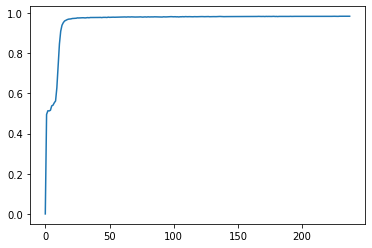

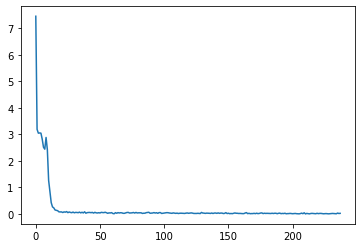

In [30]:
import matplotlib.pyplot as plt 
plt.plot(model.val_metrics['accuracy'])
plt.figure()
plt.plot(model.val_metrics['loss'])

In [31]:
@torch.no_grad()
def it_inference(begin):
    MAX_TGT_LEN = 100
    BOS_IDX = twita.TWITADS._TAGS['[BOS]']
    it_y = torch.zeros(begin.shape[0], MAX_TGT_LEN).long().cuda()
    it_y[:, 0:1] = BOS_IDX
    for i in range(1, MAX_TGT_LEN):
        pred = model(begin, it_y).argmax(dim=-1)
        it_y[:, i:i + 1] = pred[:, i:i + 1]
        #if the last pred of every sentece is EOS exit
    return it_y[:, :i + 1]

tensor([  1,  71, 271, 268, 373, 225, 225, 284, 373, 305, 264, 373,   2])

In [340]:
model.eval()
@torch.no_grad()
def it_inference(src, max_len):
    EOS_IDX = tknzr.token_to_id('[EOS]')
    it_y = torch.zeros(1, max_len).long().cuda()
    it_y[:, 0] = tknzr.token_to_id('[BOS]')
    
    for i in range(1, max_len):
        pred = model.model(src, it_y).argmax(dim=-1)
        #save the ith token
        it_y[:, i] = pred[:, i]
        print(tknzr.decode(list(it_y[0])),end='\r')
        src = it_y.clone()
        if it_y[0,i] == EOS_IDX:
            break
    return it_y

In [341]:
txt = "Ciao a tsdfdsfdutti"
t = do_tk(txt.split()).cuda()
t = t.reshape(1,*t.shape)
r = it_inference(t,255)
#tknzr.decode(list(r[0]))a

In [ ]:
print([*map(tknzr.id_to_token,(list(r[0]))),],end='\r')

In [326]:
print([*map(tknzr.id_to_token,(list(t[0]))),],end='\r')

In [71]:
b

tensor([[   1,   38,   89,  479, 1463,  290,  527,  440,   77,   35]],
       device='cuda:0')

## Self Attention

In [188]:
model = TokenOfSeqClassifier(att.TokenizedSeq2Seq(
    tknzr.get_vocab_size(), 128, tknzr.get_vocab_size(), in_seq_pad=0,
    nheads=1, N=6, dropout=0.1
    ),tknzr.get_vocab_size(), weight_decay=1e-2, amsgrad=True, lr=1e-5)

In [189]:
trainer = pl.Trainer(gpus=1, max_epochs=1000) #callbacks=[early_stopping(),checkpoints()],
trainer.fit(model,dl_train,dl_val)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params
-------------------------------------------------
0 | model       | TokenizedSeq2Seq | 1.7 M 
1 | val_acc     | PureAccuracy     | 0     
2 | val_raw_acc | Accuracy         | 0     
-------------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.865     Total estimated model params size (MB)


Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\gianl\AppData\Local\Continuum\anaconda3\envs\pytorch_env\lib\site-packages\pytorch_lightning\trainer\data_loading.py:659: UserWarning: Your `val_dataloader` has `shuffle=True`, it is strongly recommended that you turn this off for val/test/predict dataloaders.
  rank_zero_warn(
C:\Users\gianl\AppData\Local\Continuum\anaconda3\envs\pytorch_env\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


C:\Users\gianl\AppData\Local\Continuum\anaconda3\envs\pytorch_env\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 390:  16%|█▋        | 13/79 [00:07<00:38,  1.69it/s, loss=0.37, v_num=32, val_acc=0.953, val_raw_acc=0.953] 

C:\Users\gianl\AppData\Local\Continuum\anaconda3\envs\pytorch_env\lib\site-packages\pytorch_lightning\trainer\trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [193]:
t = do_tk(['[MASK]Ciao la guerra non è mai [MASK]Mont[MASK] '])
t = t.reshape(1,*t.shape).cuda()
model.eval()
with torch.no_grad():
    r = model.model(t).argmax(dim=-1)[0].cpu().numpy()
    r = list(r)
tknzr.decode(r), [*zip(map(tknzr.id_to_token,r),map(tknzr.id_to_token,t[0]))]

('@Ciao la guerra non è mai  #Mont # ',
 [('[BOS]', '[BOS]'),
  ('@', '[MASK]'),
  ('C', 'C'),
  ('iao', 'iao'),
  ('Ġla', 'Ġla'),
  ('Ġg', 'Ġg'),
  ('u', 'u'),
  ('erra', 'erra'),
  ('Ġnon', 'Ġnon'),
  ('ĠÃ¨', 'ĠÃ¨'),
  ('Ġmai', 'Ġmai'),
  ('Ġ', 'Ġ'),
  ('Ġ#', '[MASK]'),
  ('M', 'M'),
  ('on', 'on'),
  ('t', 't'),
  ('Ġ#', '[MASK]'),
  ('Ġ', 'Ġ'),
  ('[EOS]', '[EOS]')])

In [396]:
[m for m in dir(tknzr) if not str(m).startswith('_')]

['add_special_tokens',
 'add_tokens',
 'decode',
 'decode_batch',
 'decoder',
 'enable_padding',
 'enable_truncation',
 'encode',
 'encode_batch',
 'from_file',
 'get_vocab',
 'get_vocab_size',
 'id_to_token',
 'model',
 'no_padding',
 'no_truncation',
 'normalize',
 'normalizer',
 'num_special_tokens_to_add',
 'padding',
 'post_process',
 'post_processor',
 'pre_tokenizer',
 'save',
 'save_model',
 'to_str',
 'token_to_id',
 'train',
 'train_from_iterator',
 'truncation']